In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# Overview

### Goal
The goal of this project is to build models that can classify unseen BBC news articles into the correct category.

In particular, we will be using **Non-Negative Matrix Factorization (NMF)** and **Linear Support Vector Classification (LinearSVC)** which are respectively unsupervised and supervised learning techniques.

### Data
The dataset is take from **BBC News Classification** Kaggle competition.

Bijoy Bose. BBC News Classification. https://kaggle.com/competitions/learn-ai-bbc, 2019. Kaggle.

- The dataset contains 2225 BBC new articles, which has already been split into 1490 records for training and 735 for testing.
- Each row consists of the text of the header and article along with its category and an article id.
- There are 5 categories: **business, entertainment, politics, sport, and tech**.

# Exploratory Data Analysis

In [2]:
train_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
test_data = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")

In [3]:
train_data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
print(train_data.Text[0])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebbe

In [5]:
print(train_data.Text[1])

german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.6

In [6]:
# Check if any article has uppercase letter in text
exists_upper = train_data['Text'].apply(lambda x: any(char.isupper() for char in x)).any()
print("Uppercase letter in any article:", exists_upper)

Uppercase letter in any article: False


A couple of things we notice from "Text":
- All characters are in lowercase
- Apostrophes seem to have been replaced by spaces
    - e.g. worldcom's -> worldcom s
    - e.g. we're -> we re
- Periods are kept when used for ending sentences or as decimal points in numbers, but seem to be removed for titles such as "mr" and "ms".

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


There are no null entries.

Next, I'll check for duplicate entries. I'll also find the entry with the shortest text length to check if there may be any empty text.

In [8]:
# Find duplicates based on 'Text'
dupes = train_data[train_data.duplicated(subset='Text', keep=False)]

# Group by 'Text' and get ArticleIds for each duplicate article
dupe_ids = dupes.groupby('Text')['ArticleId'].apply(list).reset_index()

# Display the duplicate article IDs grouped by 'Text'
print("Number of duplicates:", len(dupe_ids))
print("Duplicate Text and ArticleIds:")
print(dupe_ids)

# Create cleaned dataframe by removing duplicates aside from the first instance
df_cleaned = train_data.drop_duplicates(subset='Text', keep='first')

Number of duplicates: 50
Duplicate Text and ArticleIds:
                                                 Text     ArticleId
0   ask jeeves joins web log market ask jeeves has...  [1098, 1326]
1   aviator  creator  in oscars snub the man who s...   [374, 1042]
2   blind student  hears in colour  a blind studen...   [1847, 145]
3   bortolami predicts dour contest italy skipper ...   [1218, 427]
4   britons fed up with net service a survey condu...   [478, 1600]
5   brown outlines third term vision gordon brown ...    [828, 494]
6   california sets fines for spyware the makers o...  [2208, 1701]
7   camera phones are  must-haves  four times more...  [2144, 1860]
8   commodore finds new lease of life the once-fam...  [1468, 1204]
9   de niro film leads us box office film star rob...  [1794, 1049]
10  debate needed  on donations cap a cap on donat...    [39, 1661]
11  digital guru floats sub-$100 pc nicholas negro...   [513, 1464]
12  doors open at biggest gadget fair thousands of...   [794

In [9]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1440 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1440 non-null   int64 
 1   Text       1440 non-null   object
 2   Category   1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.0+ KB


In [10]:
df_cleaned.loc[:,'TextLength'] = df_cleaned['Text'].apply(len)

# Get and display the row with the shortest text length
shortest_article = df_cleaned.loc[df_cleaned['TextLength'].idxmin()]

print("Row with the shortest text length:")
print(shortest_article)
print("Length of text:", shortest_article.TextLength)

Row with the shortest text length:
ArticleId                                                   324
Text          blunkett hints at election call ex-home secret...
Category                                               politics
TextLength                                                  501
Name: 573, dtype: object
Length of text: 501


<ipython-input-10-dd6a4ab6d007>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.loc[:,'TextLength'] = df_cleaned['Text'].apply(len)


There were indeed duplicates so the extras were removed.

The shortest article has length of 501 characters so it doesn't look like there are any blank articles.

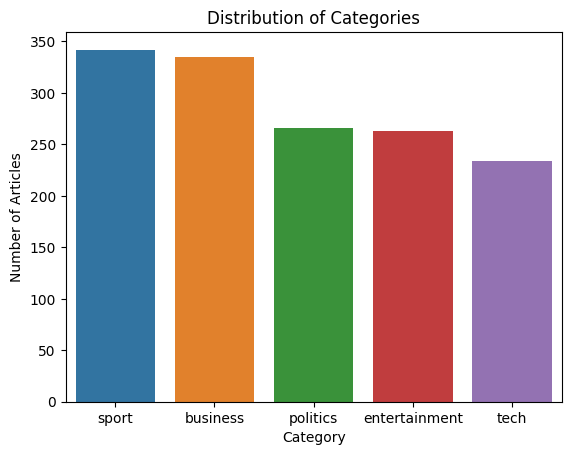

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of each category
sns.barplot(x=df_cleaned['Category'].value_counts().index, y=df_cleaned['Category'].value_counts())
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

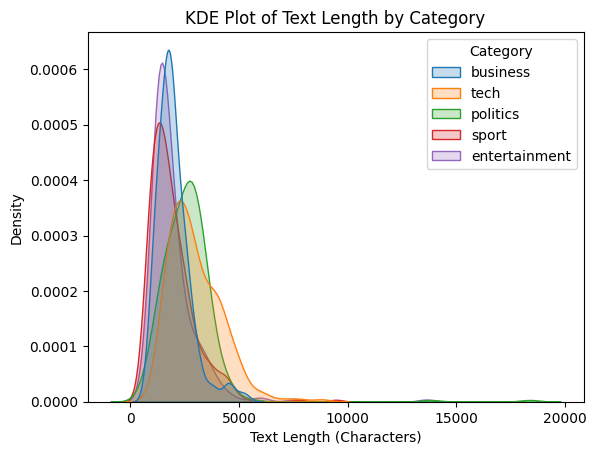

In [12]:
# KDE plot of text length grouped by Category
sns.kdeplot(data=df_cleaned, x='TextLength', hue='Category', fill=True, common_norm=False)
plt.title('KDE Plot of Text Length by Category')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Density')
plt.show()

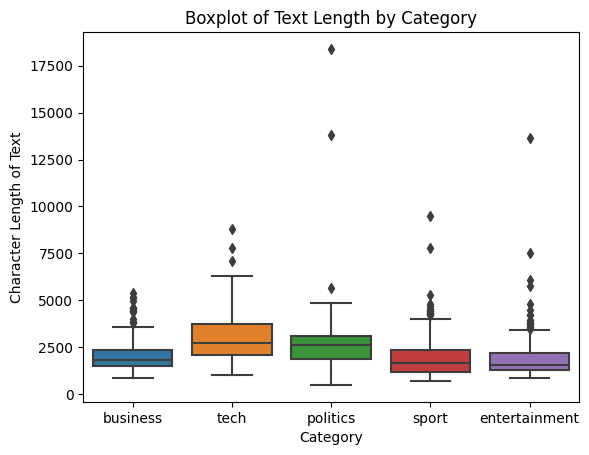

In [13]:
# Boxplots of text length grouped by Category
sns.boxplot(x='Category', y='TextLength', data=df_cleaned)
plt.title('Boxplot of Text Length by Category')
plt.xlabel('Category')
plt.ylabel('Character Length of Text')
plt.show()

The distribution of categories is fairly balanced for this dataset.

Tech and politics tend to be slightly on the longer side, but text lengths generally seem to be similar across categories.

There does seems to be a couple of extreme outliers of character lengths over 12500.

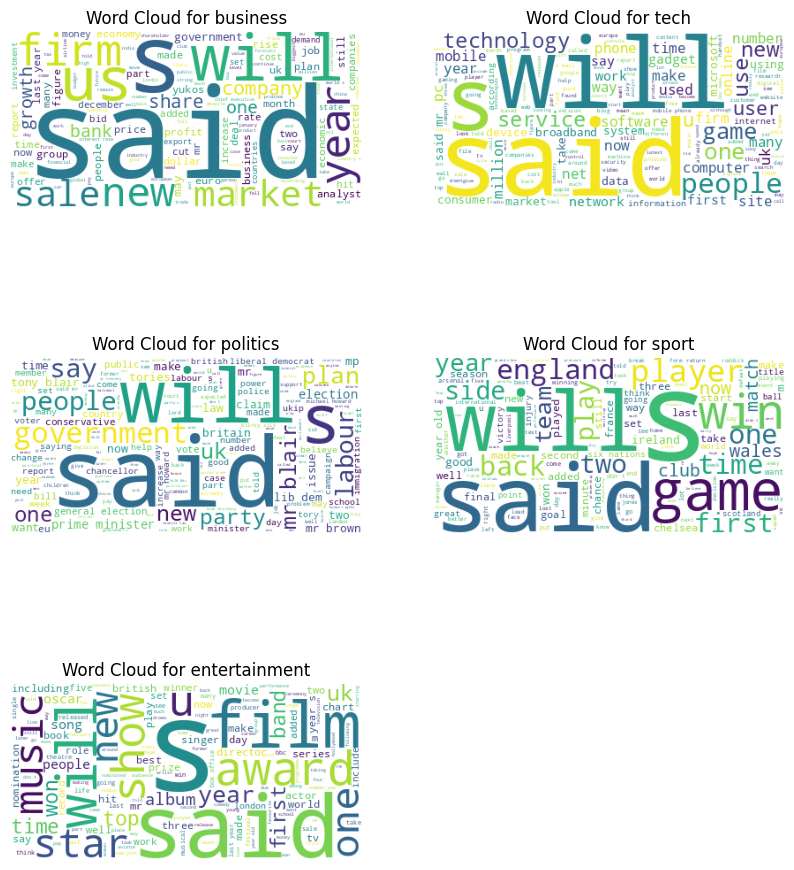

In [14]:
from wordcloud import WordCloud

categories = df_cleaned['Category'].unique()

plt.figure(figsize=(10, 12))

# Display word clouds for each category
for i, category in enumerate(categories, 1):
    category_text = " ".join(df_cleaned[df_cleaned['Category'] == category]['Text'])
    wordcloud = WordCloud(background_color='white').generate(category_text)
    plt.subplot(3, 2, i)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    
plt.show()

The word clouds above show the most common words for each category. For instance, words like "film", "music", and "award" are some of the most frequent words.

The words "will" and "said" are very frequent and "year" is also somewhat common for all categories. In general, we may want to remove generic words that won't be helpful such as words that are common in the English language (i.e. stop words).

The single letter "s" as a word is also very frequent across all categories. Earlier, we saw that apostrophes were replaced by spaces in the texts, so possessives and contractions such as "John's" and "it's" would instead appear as "John s" and "it s". As a result, the letter "s" would be treated as a single word in these cases, explaining its prominence in the word clouds.

The letter "u" is also frequent in a couple of categories. While this is just my guess, the reason might be that abbreviations such as "US" and "UK" can also be written as "U.S." and "U.K." Since titles like "Mr." and "Ms." have the periods removed, the same might be true for abbreviations written with periods. So we might have instances like "u s" and "u k". Therefore, we might consider removing all single letter words.

## Data Preprocessing

Before processing the texts as word embeddings, there are some preprocessing steps that we can apply to the text to improve model performance. Some things that were noticed from the data analysis:
- Punctuation exists in the text but might not be necessary. Therefore, **I'll remove most punctuation**.
    - For the methods that will be used for this project, punctuation for marking the ends of sentences are unnecessary since so we can remove them. Similarly, punctuation marks like parentheses (should they exist in the text) may be removed.
    - With hyphens, we could either consider replacing them with spaces to separate words, or just remove it keeping the words together. The better option of the two depends on a case-by-case basis.
        - For instance, in the word "oscar-nomination", replacing the hyphen with a space to get the two words "oscar" and "nomination" may be more useful since each may be good indicators of the entertainment category, but separating the two words in "high-definition" may cause a loss in meaning.
        - I'll choose to **replace the hyphens with spaces**, since I believe the benefits outweigh the drawbacks of doing so.
    - Removing periods also means removing decimal points in numbers. The numbers that appear in the text are in a sense "random" so the numerical values likely wouldn't be useful in the first place.
        - In general, it may be useful to **completely remove all numbers** including years which don't take decimal points. We'll also remove words like "one" and "two" which can easily be done along with digits in spaCy.
        - However, **punctuation associated with numbers such as the dollar sign or percent marks might be meaningful, so for those numbers with those symbols it may be useful to keep just the symbol as a "word"**. We do have instances like "\\$11bn", so we can just replace all numbers with spaces and just treat "\$" and "bn" as two separate words.
- There are words with the same base form, such as "said" and "say". Changing words to a common base form can help improve performance and reduce dimensionality.
    - Using either *stemming* or *lemmatization* will convert words to the same root.
    - Stemming is simpler and faster while lemmatization is slower and more computationally expensive, but lemmatization is more accurate. Since the dataset isn't too large, **I will use lemmatization**.
- Remove commonly used words from the English (e.g. "the"). In other words, remove *stop words*.
    - The word "said" very frequently shows up in all five categories, but isn't usually included as stop word, so we should add it to the list of stop words.
    - The word "year" is also somewhat common among all the categories so we'll also remove it.
    - We should do lemmatization first since "said" and "say" share the same root, and then **remove all the stop words as well as "say" and "year"**.
- We should also **remove words of one or two letters**.
    - Many of the one letter words are a result of removing apostrophes or periods from abbreviations, along with words like "a" and "I".
    - We'll make exceptions for '%' and some currency symbols. For simplicity, I'll just include the currency symbols "$", "£", and "€".
    - Two letter words can be stop words like "it" as well as contractions like "ve", "ll", and "re", so they are better off removed. There can also be two letter abbreviations such as "UK" or "Mr" and words like "ad" which can be meaningful, but may be more beneficial to just simply remove all two letter words.

I will be using **spaCy** for most of the preprocessing of the text. Afterwards, we'll see how the changes are reflected in a new set of word clouds.

In [15]:
import spacy
import string
import re
import time

nlp = spacy.load("en_core_web_sm")

# Add "say" and "year" to stop words
nlp.vocab["say"].is_stop = True
nlp.vocab["year"].is_stop = True

# Function that return the processed text string
def process_text(text):
    # Replace hyphens with spaces
    text = text.replace('-', ' ')

    # Replace digits with spaces
    text = re.sub(r'\d', ' ', text)
    
    # Process the text with spaCy
    doc = nlp(text)

    # 
    special_symbols = "%$£€"
    
    # Filter out punctuation except '$' and '%'
    tokens = [
        token for token in doc
        if not token.is_punct or token.text in special_symbols
    ]

    # Lemmatize each token, turning the resulting string back to a Token object
    tokens = [nlp.make_doc(token.lemma_)[0] for token in tokens]
    
    # Apply remaining filter conditions
    tokens = [
        token.text for token in tokens
        if (len(token.text) > 2 or # Remove 1-2 character words
            token.text in special_symbols) # Don't remove special symbols
        and not token.is_stop # Remove stop words
        and not token.like_num  # Remove numbers
        and not token.is_space # Remove tokens with just spaces
    ]

    # Return the processed text
    return ' '.join(tokens)

# Return the data with a new 'Processed_Text' column and prints the runtime
def preprocess_data(data):
    start_time = time.time()
    data['Processed_Text'] = data['Text'].apply(process_text)
    print(f"Processing took {round(time.time() - start_time, 2)} seconds.\n")
    return data

In [16]:
# Preprocess the cleaned training set
df_processed = preprocess_data(df_cleaned)

print("Unprocessed Text:", df_processed['Text'][0])
print()
print("Processed Text:", df_processed['Processed_Text'][0])

Processing took 114.98 seconds.

Unprocessed Text: worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the

<ipython-input-15-93dfa0157c1b>:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Processed_Text'] = data['Text'].apply(process_text)


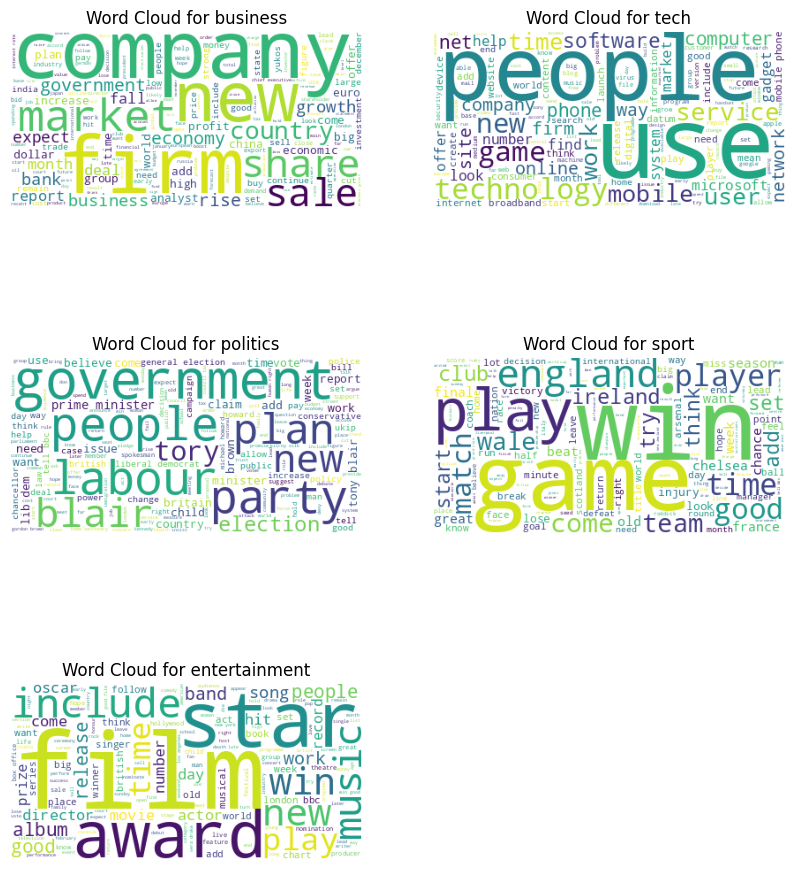

In [17]:
plt.figure(figsize=(10, 12))

# Display word clouds on the processed text for each category
for i, category in enumerate(categories, 1):
    category_text = " ".join(df_processed[df_processed['Category'] == category]['Processed_Text'])
    wordcloud = WordCloud(background_color='white').generate(category_text)

    plt.subplot(3, 2, i)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word Cloud for {category}')
    
plt.show()

We can see from the word clouds that we have removed some of the noise. We can now see words that are very characteristic for certain categories, as well as words that are common for two or more categories.

I'll also apply the preprocessing to the test set.

In [18]:
# Preprocess the test set
X_test_text = preprocess_data(test_data)['Processed_Text']

Processing took 59.45 seconds.



## Word Embedding

Now that I have cleaned and preprocessed the data, I will process the text to word embeddings since the machine learning algorithms cannot work with the raw text. In particular, I will used scikit learn's TfidfVectorizer to process the raw texts to feature vectors based on the TF-IDF score.

### TF-IDF (Term Frequency-Inverse Document Frequency)

The TF-IDF score of a word in a document (in this case, a document is the text of an article) is the product of the **Term Frequency (TF)** and **Inverse Document Frequency (IDF)**.
- TF represents the frequency of a word in a document. The more times that a word appears in a document, the higher the TF score.
- IDF is the log of the ratio of the total number of documents to the number of documents containing the word. It reduces the weight of common words while increasing the weight of rare words.
  - IDF helps balance the TF score.
  - The idea is that rare words may be more specific and meaningful, while words that appear in many documents might not be very useful in telling apart different documents.

The TF-IDF method is relatively simple and computationally inexpensive. However, it cannot deal with semantics such as the relationships between words.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# Convert processed text to a sparse matrix of TF-IDF features for X_train
X_train = vectorizer.fit_transform(df_processed['Processed_Text'])
X_test = vectorizer.transform(X_test_text)

# Get the target column 'Categories'
y_train = df_processed['Category']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Model Building

We will be building and training two models using Non-Negative Matrix Factorization and Linear Support Vector Classification.

## Non-Negative Matrix Factorization (NMF)

NMF factorizes a matrix X into two non-negative matrices W and H such that X = WH.

If X is an m x n matrix such that m is the number of articles and n is the number of unique words, we can factorize X into an m x d matrix W and d x n matrix H. The latent dimension d may represent the number of categories, which in this case is 5.

Therefore, we would like to perform NMF on the feature matrix X with 5 components (topic) that represent the 5 different categories. Then we'll map each topic to a category based on the majority category of the articles classified under each topic. And finally, we'll transform X_test using the NMF model and classify based on those mappings.

When training the unsupervised model for matrix factorization, we shouldn't include texts (word features) from the test dataset as part of the input matrix as it should be considered unseen data and including it can lead to data leakage even when the true labels aren't included.

I'll make an estimator that takes the same parameters as NMF and fits NMF to the training data. It'll make predictions based on the most likely category for each article based on matrix W.

Once the model is trained, I'll get the accuracy scores for the predictions made on the training data and cross-validation as well as the confusion matrix for the cross-validation predictions, then submit the test predictions to Kaggle to get the accuracy score for the test set.

In [20]:
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator

# NMF classifier which take the same parameters as NMF
class NMFClassifier(BaseEstimator):
    def __init__(self, **nmf_params):
        self.nmf = NMF(**nmf_params)
        self.mapping = {}

    def fit(self, X, y):
        W = self.nmf.fit_transform(X)
        self.create_mapping(W, y)
        return self

    # Update mapping of component to category
    def create_mapping(self, W, y):
        # For each row, get the index of the column with the highest value
        best_topics = np.argmax(W, axis=1)

        for topic in range(self.nmf.n_components_):
            # Get all rows in y for topic, and map topic to the most common category in y
            self.mapping[topic] = y[best_topics == topic].mode()[0]
    
    def predict(self, X):
        W = self.nmf.transform(X)
        return [self.mapping[i] for i in np.argmax(W, axis=1)]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

    def get_params(self, deep=True):
        params = self.nmf.get_params(deep)
        return params

    def set_params(self, **params):
        nmf_params = {key: value for key, value in params.items() if key in self.nmf.get_params()}
        self.nmf.set_params(**nmf_params)
        return self

In [21]:
# Fit NMF classifier to X_train
nmf_mod = NMFClassifier(n_components=5, random_state=4)
nmf_mod.fit(X_train, y_train)
print("Mapping:", nmf_mod.mapping)

Mapping: {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}


In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Display heatmap of the confusion matrix
def display_cm(y, y_pred, mod_name):
    labels = np.unique(y)
    cm = confusion_matrix(y, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.title(f"Confusion Matrix for {mod_name}")
    plt.show()

Training Score: 0.9270833333333334
Cross-Validation Score: 0.9041666666666667


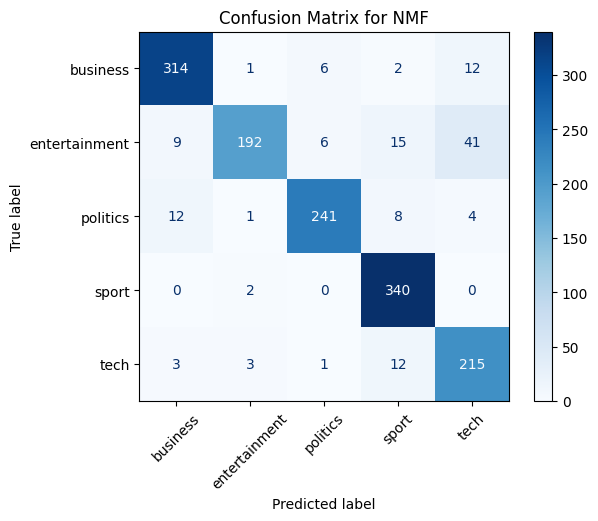

In [23]:
from sklearn.model_selection import cross_val_predict

# Print accuracy score for training set
print("Training Score:", nmf_mod.score(X_train, y_train))

# Print accuracy score for cross-validation
cv_pred = cross_val_predict(nmf_mod, X_train, y_train, cv=5)
print("Cross-Validation Score:", accuracy_score(y_train, cv_pred))

# Display confusion matrix
display_cm(y_train, cv_pred, "NMF")

In [24]:
# Submit test predictions for the NMF classifier to Kaggle
predictions = nmf_mod.predict(X_test)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_nmf.csv', index=False)

We get an accuracy score of 0.92708 for the training set and 0.90417 for cross-validation, so there may be some overfitting.

After submitting to Kaggle, we get an accuracy of **0.93605** for the test set so overfitting might not actually be an issue here.

From the confusion matrix, we can see of the common misclassifications. Entertainment articles seem to be most prone to misclassification. In particular, 41 entertainment articles were misclassified as tech. It seems to do well at classifying sports articles, however.

It's completely expected that there will be overlaps in topics for certain new articles, such as computers being a large component in many areas of entertainment industries. Also, there are certain articles that would be hard to classify without context such as an entertainment article that heavily talks about the contents of a TV crime show. So it makes sense that these types of articles can be easily confused for another category, or arguably could fall under multiple categories.

### NMF Classifier Hyperparameter Tuning

Both TfidfVectorizer and NMF can be tuned so I'll create a pipeline for TfidfVectorizer and NMFClassifier, then use GridSearchCV to tune some of the hyperparameters.

In [25]:
# Get the raw processed text for train and test sets to be used with the new classifier
X_train_text = df_processed['Processed_Text']

In [26]:
# Print the hyperparameters and score of top 20 best estimators in descending order of score
def grid_search_results(results):
    df_results = pd.DataFrame({
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })
    params_df = df_results['params'].apply(pd.Series)
    final_df = pd.concat([df_results['mean_test_score'], params_df], axis=1)
    final_df = final_df.sort_values(by='mean_test_score', ascending=False)
    final_df = final_df.reset_index(drop=True)[:20]
    display(final_df)

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Pipeline chaining TfidfVectorizer and NMFClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMFClassifier(n_components=5, random_state=4))
])

param_grid = [
    {
        'tfidf__ngram_range': [(1, 2), (1, 3)],
        'tfidf__min_df': [1, 2, 3],
        'tfidf__max_features': [7500, 8000, 8500],
        'nmf__solver': ['mu'],
        'nmf__beta_loss': ['kullback-leibler'],
    }
]

nmf_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
nmf_grid_search.fit(X_train_text, y_train)

print("Best parameters:", nmf_grid_search.best_params_)
print("Best score: ", nmf_grid_search.best_score_)
grid_search_results(nmf_grid_search.cv_results_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'nmf__beta_loss': 'kullback-leibler', 'nmf__solver': 'mu', 'tfidf__max_features': 8000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3)}
Best score:  0.9638888888888888


,mean_test_score,nmf__beta_loss,nmf__solver,tfidf__max_features,tfidf__min_df,tfidf__ngram_range
0,0.963889,kullback-leibler,mu,8000,2,"(1, 3)"
1,0.963194,kullback-leibler,mu,7500,2,"(1, 3)"
2,0.963194,kullback-leibler,mu,7500,3,"(1, 2)"
3,0.962500,kullback-leibler,mu,7500,2,"(1, 2)"
4,0.961806,kullback-leibler,mu,8500,2,"(1, 3)"
5,0.961806,kullback-leibler,mu,8000,2,"(1, 2)"
6,0.961111,kullback-leibler,mu,8500,1,"(1, 3)"
7,0.960417,kullback-leibler,mu,8000,3,"(1, 2)"
8,0.959722,kullback-leibler,mu,8000,3,"(1, 3)"
9,0.959722,kullback-leibler,mu,7500,1,"(1, 2)"


I ran the previous cell a number of times while fine-tuning the parameters to get a good set of hyperparameters.

A number of the parameters that I had tried tuning either performed the best on the default value or didn't seem to make any difference in the accuracy score.

The parameters that did make a significant difference are
- min_df, ngram_range, and max_features for the TfidfVectorizer
- solver and beta_loss for NMF

Keeping TfidfVectorizer parameters at the default values, the NMF's 'kullback-leibler' beta_loss and 'mu' solver parameters gave the biggest improvement, yielding about 0.03 higher accuracy compared to all other combinations of solver and beta_loss.

The next biggest improvement came from changing TfidfVectorizer's ngram_range parameter from the default (1, 1). An n-gram is a string of n consecutive words. For example, in the sentence "This is a sentence", "is a" is a 2-gram (or bigram) and "is a sentence" is a 3-gram (or trigram). The parameter takes a tuple (min_n, max_n) in which all n-grams where min_n <= n <= max_n will be included as features. The default (1, 1) only includes single-word features. (1,3) would include unigrams, bigrams, and trigrams.

It turns out that including bigrams and/or trigrams increased importance by around an additional 0.02. Since we're adding many more features, many of which aren't useful or could even lead to overfitting, we can change some of the other parameters to reduce the dimensionality of the feature space. In particular, reducing max_features of around 8000 seems to be the sweet spot. The min_df parameter seems to be more variable as to which value may be best depending on the other parameters chosen.

Training Score: 0.9597222222222223
Cross-Validation Score: 0.9638888888888889


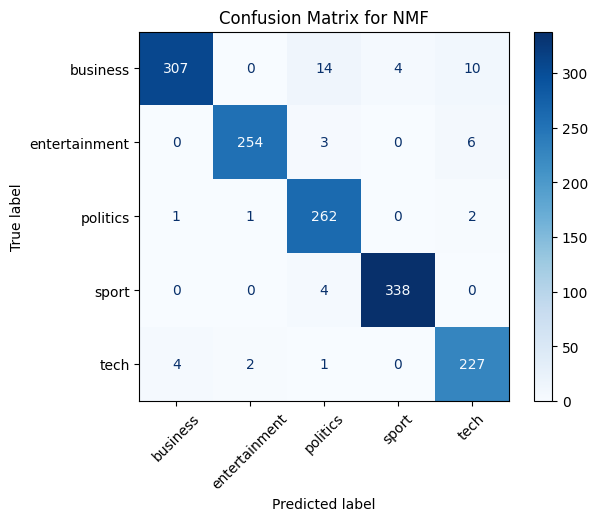

In [28]:
nmf_mod2 = nmf_grid_search.best_estimator_

# Print accuracy score for training set
print("Training Score:", nmf_mod2.score(X_train_text, y_train))

# Print accuracy score for cross-validation
cv_pred = cross_val_predict(nmf_mod2, X_train_text, y_train, cv=5)
print("Cross-Validation Score:", accuracy_score(y_train, cv_pred))

# Display confusion matrix
display_cm(y_train, cv_pred, "NMF")

In [29]:
# Submit predictions for the new NMF classifier to Kaggle
predictions = nmf_mod2.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_nmf_mk2.csv', index=False)

The confusion matrix shows that other than business, it seems to do a lot better at classifying the other types of articles, especially improving on classifying entertainment articles correctly.

There are much better improvements in accuracy for both training and CV. The CV score is slightly higher but not so high that we'd need to be concerned, but it does seem that be have reduced the overfitting.

The new model resulted in a **0.97006** accuracy on the test set, which is a significant improvement over the previous score of 0.93605. This score is about about a percent higher than the training score, but it could just be that the test data is a bit easier to predict compared to the training data.

## Linear Support Vector Classification (Linear SVC)
LinearSVC is based on the Support Vector Machine algorithm, which classifies the data points by finding the hyperplanes that best separate them. Compared to SVC which uses a kernel trick which can handle both linear and nonlinear decision boundaries, LinearSVC is specifically optimized for linearly separable boundaries and is instead implemented with liblinear rather than libsvm. In addition, LinearSVC is more flexible with the choice of penalties and loss functions, and it scales better to larger datasets which can help deal with the large vectorized feature matrix. Therefore, I have chosen to use LinearSVC over SVC.

I'll create a pipeline with TfidfVectorizer and LinearSVC and perform grid search on the pipeline. Since there are many combinations of parameters, I'll first do grid search on just the parameters for the vectorizer with the default parameters for LinearSVC. Then I'll fit the text to the vectorizer with the best parameters, and do grid search on LinearSVC fitted to the new feature matrix.

In [30]:
from sklearn.svm import LinearSVC

# Pipeline chaining TfidfVectorizer and LinearSVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lsvc', LinearSVC())
])

param_grid = [
    {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__max_features': [None],
        'tfidf__min_df': [1, 2, 3],
        'tfidf__sublinear_tf': [True]
    }
]
            
# Create GridSearchCV object
lsvc_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
lsvc_grid_search.fit(X_train_text, y_train)

# Get the best vectorizer parameters and remove the 'tfidf__' prefixes
vec_params = {key[7:]: value for key, value in lsvc_grid_search.best_params_.items() if key.startswith('tfidf__')}

print("Best vectorizer parameters:", vec_params)
print("Best score: ", lsvc_grid_search.best_score_)
grid_search_results(lsvc_grid_search.cv_results_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best vectorizer parameters: {'max_features': None, 'min_df': 2, 'ngram_range': (1, 2), 'sublinear_tf': True}
Best score:  0.9770833333333334


,mean_test_score,tfidf__max_features,tfidf__min_df,tfidf__ngram_range,tfidf__sublinear_tf
0,0.977083,None,2,"(1, 2)",True
1,0.977083,None,2,"(1, 3)",True
2,0.976389,None,1,"(1, 2)",True
3,0.975694,None,1,"(1, 3)",True
4,0.975000,None,3,"(1, 1)",True
5,0.975000,None,3,"(1, 2)",True
6,0.975000,None,3,"(1, 3)",True
7,0.974306,None,1,"(1, 1)",True
8,0.974306,None,2,"(1, 1)",True


In [31]:
# Initialize new vectorizer with best parameters from previous grid search
vectorizer_new = TfidfVectorizer(**vec_params)

# Fit and transform the raw text training data, and transform the test data
X_train_new = vectorizer_new.fit_transform(X_train_text)
X_test_new = vectorizer_new.transform(X_test_text)

In [32]:
param_grid = [
    {
        'penalty': ['l1'],
        'loss': ['squared_hinge'],
        'dual': [False],
        'C': [0.1, 1, 10, 100],
        'max_iter': [1000, 2000]
    },
    {
        'penalty': ['l2'],
        'loss': ['hinge', 'squared_hinge'],
        'C': [0.1, 1, 10, 100],
        'max_iter': [1000, 2000]
    }
]
            
# Create GridSearchCV object
lsvc2_grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the data
lsvc2_grid_search.fit(X_train_new, y_train)

print("Best parameters:", lsvc2_grid_search.best_params_)
print("Best score: ", lsvc2_grid_search.best_score_)
grid_search_results(lsvc2_grid_search.cv_results_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'C': 1, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Best score:  0.9770833333333334


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,mean_test_score,C,dual,loss,max_iter,penalty
0,0.977083,1.0,NaN,hinge,1000,l2
1,0.977083,1.0,NaN,hinge,2000,l2
2,0.977083,100.0,NaN,squared_hinge,1000,l2
3,0.977083,100.0,NaN,hinge,2000,l2
4,0.977083,100.0,NaN,hinge,1000,l2
5,0.977083,10.0,NaN,squared_hinge,2000,l2
6,0.977083,10.0,NaN,squared_hinge,1000,l2
7,0.977083,10.0,NaN,hinge,2000,l2
8,0.977083,10.0,NaN,hinge,1000,l2
9,0.977083,1.0,NaN,squared_hinge,2000,l2


Tuning the parameters for TfidfVectorizer produced improvements but it seems that changing the parameters for LinearSVC from the default doesn't seem to do much, so I'll keep the default parameter values for LinearSVC.

Training Score: 1.0
Cross-Validation Score: 0.9770833333333333


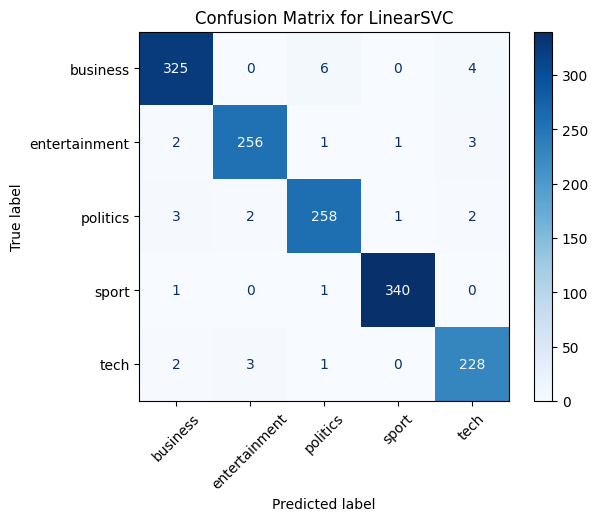

In [33]:
lsvc_mod = lsvc_grid_search.best_estimator_

# Print accuracy score for training set
print("Training Score:", lsvc_mod.score(X_train_text, y_train))

# Print accuracy score for cross-validation
cv_pred = cross_val_predict(lsvc_mod, X_train_text, y_train, cv=5)
print("Cross-Validation Score:", accuracy_score(y_train, cv_pred))

# Display confusion matrix
display_cm(y_train, cv_pred, "LinearSVC")

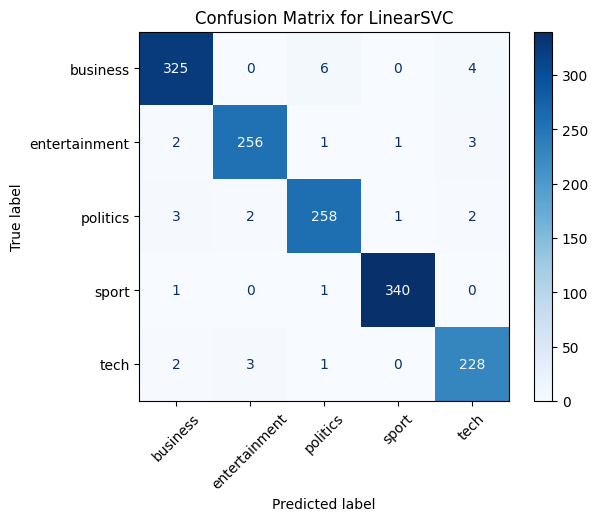

In [34]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(lsvc_mod, X_train_text, y_train, cv=5)
display_cm(y_train, y_pred, "LinearSVC")

In [35]:
# Submit predictions for LinearSVC to Kaggle
predictions = lsvc_mod.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_lsvc.csv', index=False)

The LinearSVC model got a perfect score on the training data, which we can also see from the confusion matrix. It received a 0.97708 for cross-validation. This is an improvement from the NMF classifier, but there also seems to be some overfitting.

We also see that compared to the NMF classifier, it improves on classifying business articles.

After submitting the test predictions to Kaggle, it got a score of **0.98095** which is a one percent improvement over the NMF classifier.

## Comparison between NMF and LinearSVC Models

We now have an NMF classifier and a linear support vector classifier. We saw that LinearSVC supervised learning approach performed a bit better than the NMF unsupervised learning approach for predicting categories. However, we can also compare how well they perform when fitted on different subsets of the training data.

I will split the data into nine subsets of 10%, 20%, ... , 90% and use the remaining data as test sets. For example, doing a 40:60 train-test split would put 40% of the data in the training set and 60% in the test set. This way, I won't need to submit each prediction to Kaggle to evaluate each model.

For each split, I'll fit the training subset to each of the two models and get the accuracy of the predictions on both the training and test subsets, which I'll then plot for comparison between the training and test accuracy as well as between models.

In addition, I'll stratify the train-test splits. This ensures that the categories are equally represented in the training and test sets after the split.

In [36]:
from sklearn.base import clone
from sklearn.model_selection import train_test_split

# Returns list of scores from model clf fitted on subsets of the data
# train_acc_100 and test_acc_100 are the training and test accuracy scores for the model fit on the full training set 
def score_subsets(clf, X, y, train_acc_100, test_acc_100):
    clf_sub = clone(clf)
    train_accs = []
    test_accs = []
    
    # Loop over train sizes from 0.1 to 0.9
    for i in range(1, 10):
        train_size = i / 10
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, stratify=y, random_state=4)
        
        clf_sub.fit(X_train, y_train)
        y_train_pred = clf_sub.predict(X_train)
        y_test_pred = clf_sub.predict(X_test)
        
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        
        train_accs.append(train_acc)
        test_accs.append(test_acc)

    train_accs.append(train_acc_100)
    test_accs.append(test_acc_100)
    
    return train_accs, test_accs

# Function to plot training and test accuracies
# acc_pairs is a list of tuple (train_accs, test_accs)
def plot_accuracies(acc_pairs, labels, colors):
    # Train_sizes from 0.1 to 1.0
    train_sizes = [i / 10 for i in range(1, 11)]
    
    for i, (train_accs, test_accs) in enumerate(acc_pairs):
        plt.plot(train_sizes, train_accs, label=f'Train ({labels[i]})', linestyle=':', color=colors[i])
        plt.plot(train_sizes, test_accs, label=f'Test ({labels[i]})', linestyle='-', color=colors[i])
        
    plt.xlabel('Train Size')
    plt.ylabel('Accuracy')
    plt.title('Train Size vs Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [37]:
nmf_accs = score_subsets(nmf_mod2, X_train_text, y_train, 0.95972, 0.97006)
lsvc_accs = score_subsets(lsvc_mod, X_train_text, y_train, 1.0, 0.98095)

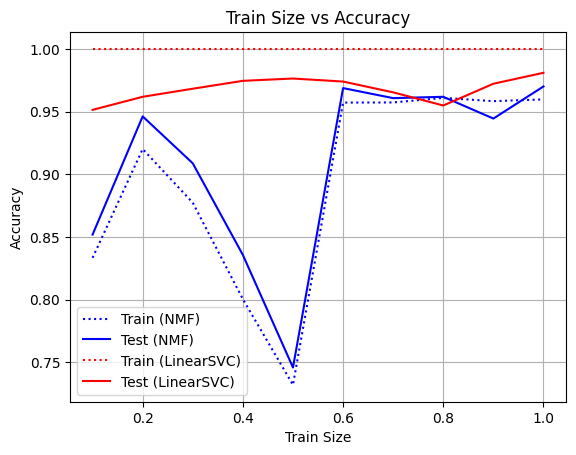

In [38]:
# Plot Train Size and Test Accuracy for NMF classifier and LinearSVC
plot_accuracies([nmf_accs, lsvc_accs], labels=['NMF', 'LinearSVC'], colors=['blue', 'red'])

In [39]:
print(f"Train (NMF) at 0.2: {nmf_accs[0][1]}")
print(f"Test  (NMF) at 0.2: {nmf_accs[1][1]}")
print(f"Train (NMF) at 0.6: {nmf_accs[0][5]}")
print(f"Test  (NMF) at 0.6: {nmf_accs[1][5]}")
print(f"Train (LinearSVC) at 0.2: {lsvc_accs[0][1]}")
print(f"Test  (LinearSVC) at 0.2: {lsvc_accs[1][1]}")
print(f"Train (LinearSVC) at 0.6: {lsvc_accs[0][5]}")
print(f"Test  (LinearSVC) at 0.6: {lsvc_accs[1][5]}")

Train (NMF) at 0.2: 0.9201388888888888
Test  (NMF) at 0.2: 0.9461805555555556
Train (NMF) at 0.6: 0.9571759259259259
Test  (NMF) at 0.6: 0.96875
Train (LinearSVC) at 0.2: 1.0
Test  (LinearSVC) at 0.2: 0.9618055555555556
Train (LinearSVC) at 0.6: 1.0
Test  (LinearSVC) at 0.6: 0.9739583333333334


We see some interesting results:
- Test score being significantly lower than the training score is a sign of overfitting.
    - We see that there is a couple percent difference between training and test scores for all train sizes for LinearSVC, and training accuracy is perfect for all train sizes. It seems that the model is overfitting to the training set.
    - The NMF classifier seems better at dealing with overfitting. In fact, test accuracy are higher than the training accuracy for most subset sizes. It could be possible that there is some underfitting, although at larger sample sizes the difference isn't too large to be of concern.
- NMF has a dip between 0.2 and 0.6 so there is underfitting for the subsets in between, but this might just be due inappropriate parameter values.

I'll try fitting both models again to training sizes of 20% and 60%, and submit the results to Kaggle to see how they do.

In [40]:
# Split the data but only keep the training sets
X_train_20, _, y_train_20, _ = train_test_split(X_train_text, y_train, train_size=0.2, stratify=y_train, random_state=4)
X_train_60, _, y_train_60, _ = train_test_split(X_train_text, y_train, train_size=0.6, stratify=y_train, random_state=4)

# Clone the models and fit to 60% training set
nmf_sub = clone(nmf_mod2)
lsvc_sub = clone(lsvc_mod)

# Fit to 20% training set
nmf_sub.fit(X_train_20, y_train_20)
lsvc_sub.fit(X_train_20, y_train_20)

# Submit predictions for NMF classifier fit on 20% training data to Kaggle
predictions = nmf_sub.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_nmf_20.csv', index=False)

# Submit predictions for LinearSVC fit on 20% training data to Kaggle
predictions = lsvc_sub.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_lsvc_20.csv', index=False)

# Fit to 60% training set
nmf_sub.fit(X_train_60, y_train_60)
lsvc_sub.fit(X_train_60, y_train_60)

# Submit predictions for NMF classifier fit on 60% training data to Kaggle
predictions = nmf_sub.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_nmf_60.csv', index=False)

# Submit predictions for LinearSVC fit on 60% training data to Kaggle
predictions = lsvc_sub.predict(X_test_text)
output = pd.DataFrame({'ArticleId': test_data.ArticleId, 'Category': predictions})
output.to_csv('submission_lsvc_60.csv', index=False)

With 60% of the training set, we get accuracies of **0.96598 for NMF** and **0.97823 for LinearSVC**. With 20%, we get accuracies of **0.94013 for NMF** and **0.96598 for LinearSVC**.

Let's try doing grid search on the 50% training set to see if the parameter values are the issue.

In [41]:
# Build TfidfVectorizer and NMFClassifier pipeline and train on 50% of training data

X_train_50, X_test_50, y_train_50, y_test_50 = train_test_split(X_train_text, y_train, train_size=0.5, stratify=y_train, random_state=4)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMFClassifier(n_components=5, random_state=4))
])

param_grid = [
    {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__min_df': [1, 2, 3],
        'tfidf__max_features': [7500, 8000, 8500],
        'nmf__solver': ['mu'],
        'nmf__beta_loss': ['kullback-leibler'],
    }
]

nmf_50_grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
nmf_50_grid_search.fit(X_train_50, y_train_50)

print("Best parameters:", nmf_50_grid_search.best_params_)
print("Best score: ", nmf_50_grid_search.best_score_)
grid_search_results(nmf_50_grid_search.cv_results_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'nmf__beta_loss': 'kullback-leibler', 'nmf__solver': 'mu', 'tfidf__max_features': 7500, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best score:  0.9416666666666667


,mean_test_score,nmf__beta_loss,nmf__solver,tfidf__max_features,tfidf__min_df,tfidf__ngram_range
0,0.941667,kullback-leibler,mu,7500,1,"(1, 1)"
1,0.931944,kullback-leibler,mu,8000,1,"(1, 1)"
2,0.929167,kullback-leibler,mu,8500,1,"(1, 1)"
3,0.886111,kullback-leibler,mu,7500,3,"(1, 3)"
4,0.886111,kullback-leibler,mu,8500,3,"(1, 2)"
5,0.886111,kullback-leibler,mu,8000,3,"(1, 3)"
6,0.886111,kullback-leibler,mu,8000,3,"(1, 2)"
7,0.886111,kullback-leibler,mu,8500,3,"(1, 3)"
8,0.886111,kullback-leibler,mu,7500,3,"(1, 2)"
9,0.880556,kullback-leibler,mu,8000,2,"(1, 1)"


In [42]:
nmf_50 = nmf_50_grid_search.best_estimator_

# Print accuracy score for 50% training set
print("Training Score:", nmf_50.score(X_train_50, y_train_50))

# Print accuracy score for 50% test set
print("Test Score:", nmf_50.score(X_test_50, y_test_50))

Training Score: 0.9361111111111111
Test Score: 0.9555555555555556


It does seem like the choice of parameters was the issue, and setting them appropriately will give good results. In particular, reducing the ngram range to only include unigrams helped immensely.

# Conclusion

|Method                     |Training Accuracy|Validation Accuracy|Test Accuracy|
|:--------------------------|:---------------:|:-----------------:|:-----------:|
|NMF (100% Train Size)      |0.95972          |0.96389            |0.97006      |
|NMF (60% Train Size)       |0.95718          |0.96875            |0.96598      |
|NMF (20% Train Size)       |0.92014          |0.94618            |0.94013      |
|LinearSVC (100% Train Size)|1.00000          |0.97708            |0.98095      |
|LinearSVC (60% Train Size) |1.00000          |0.97396            |0.97823      |
|LinearSVC (20% Train Size) |1.00000          |0.96181            |0.96598      |

The LinearSVC supervised learning approach performed a bit better than the NMF unsupervised learning approach.

NMF seems to be more prone to underfitting with the wrong choice of hyperparameters. In particular, it seems that the way that the raw text is converted into the feature matrix can greatly influence the performance of the model and can be highly dependent on which texts are included in the dataset. With the correct parameters, it can still yield good results.

Both approaches can work well on smaller training set sizes, but LinearSVC tends to overfit slightly more as the training set gets smaller while NMF seems to handle overfitting well even at smaller training set sizes

## Reference

- DeepLearning.ai. (n.d.). Natural language processing. https://www.deeplearning.ai/resources/natural-language-processing/
- Explosion AI. (n.d.). spaCy documentation. https://spacy.io/
GeeksforGeeks - Understanding TF-IDF (Term Frequency-Inverse Document Frequency):
- GeeksforGeeks. (2021, March 30). Understanding TF-IDF (Term Frequency-Inverse Document Frequency). https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
- scikit-learn. (2021, March). sklearn.feature_extraction.text.TfidfVectorizer. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
scikit-learn - LinearSVC:
- scikit-learn. (2021, March). sklearn.svm.LinearSVC. https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
